# Tutorial 4: Interactive Data Visualization

#### Suhas Somnath
8/8/2017

This set of tutorials will serve as examples for developing end-to-end workflows for and using pycroscopy. 

__In this example, we will learn how to visualize multidimensional datasets interactively using widgets.__

## Introduction

Often, one is interested in interactively visualizing multidimensional data to better understand and interpret data. Jupyter Widgets make such interactivity possible. We will be demonstrating a simple interactive visualizer that will slice a 6 dimensional dataset to visualize 2 dimensional spectrograms according to the interactive slicing parameters.  

In [1]:
# downloading packages:
!pip install -U wget numpy h5py matplotlib Ipython ipywidgets pycroscopy

# Ensure python 3 compatibility:
from __future__ import division, print_function, absolute_import, unicode_literals

# The package for accessing files in directories, etc.:
import os
import wget

# The mathematical computation package:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Packages for plotting:
import matplotlib.pyplot as plt

# basic interactive widgets:
from IPython.display import display
import ipywidgets as widgets

# Finally import pycroscopy for certain scientific analysis:
import pycroscopy as px

# set up notebook to show plots within the notebook
% matplotlib inline

Requirement already up-to-date: wget in /Users/syz/anaconda/lib/python3.5/site-packages
Requirement already up-to-date: numpy in /Users/syz/anaconda/lib/python3.5/site-packages
Requirement already up-to-date: h5py in /Users/syz/anaconda/lib/python3.5/site-packages
Requirement already up-to-date: matplotlib in /Users/syz/anaconda/lib/python3.5/site-packages
Requirement already up-to-date: Ipython in /Users/syz/anaconda/lib/python3.5/site-packages
    100% |████████████████████████████████| 71kB 1.9MB/s ta 0:00:011
Requirement already up-to-date: pycroscopy in /Users/syz/anaconda/lib/python3.5/site-packages/pycroscopy-0.0.53-py3.5.egg
Requirement already up-to-date: six in /Users/syz/anaconda/lib/python3.5/site-packages (from h5py)
Requirement already up-to-date: pytz in /Users/syz/anaconda/lib/python3.5/site-packages (from matplotlib)
Requirement already up-to-date: python-dateutil in /Users/syz/anaconda/lib/python3.5/site-packages (from matplotlib)
Requirement already up-to-date: pypar

  Found existing installation: ipywidgets 6.0.0
    Uninstalling ipywidgets-6.0.0:
      Successfully uninstalled ipywidgets-6.0.0
  Found existing installation: scikit-learn 0.18.2
    Uninstalling scikit-learn-0.18.2:
      Successfully uninstalled scikit-learn-0.18.2
  Found existing installation: xlrd 1.0.0
    Uninstalling xlrd-1.0.0:
      Successfully uninstalled xlrd-1.0.0


## Load the dataset

For this example, we will be working with a Band Excitation Polarization Switching (BEPS) First Order Reversal Curve (FORC) dataset acquired from advanced atomic force microscopes. In the much simpler Band Excitation (BE) imaging datasets, a single spectra is acquired at each location in a two dimensional grid of spatial locations. Thus, BE imaging datasets have two position dimensions (X, Y) and one spectroscopic dimension (frequency - against which the spectra is recorded). The BEPS-FORC dataset used in this example has a spectra for each combination of three other paramaters (DC offset, Field, bias waveform type {FORC}). Thus, this dataset has three new spectral dimensions in addition to the spectra itself. Hence, this dataet becomes a 2+4 = 6 dimensional dataset

In [ ]:
# download the raw data file from Github:
h5_path = 'temp.h5'
url = 'https://raw.githubusercontent.com/pycroscopy/pycroscopy/master/data/BEPS_small.h5'
if os.path.exists(h5_path):
    os.remove(h5_path)
_ = wget.download(url, h5_path)

In [2]:
h5_path = px.

In [3]:
# Open the file in read-only mode
h5_file = h5py.File(h5_path, mode='r')

print('Datasets and datagroups within the file:\n------------------------------------')
px.hdf_utils.print_tree(h5_file)

Datasets and datagroups within the file:
------------------------------------
/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Bin_FFT
Measurement_000/Channel_000/Bin_Frequencies
Measurement_000/Channel_000/Bin_Indices
Measurement_000/Channel_000/Bin_Step
Measurement_000/Channel_000/Bin_Wfm_Type
Measurement_000/Channel_000/Excitation_Waveform
Measurement_000/Channel_000/Noise_Floor
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Guess
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Spectroscopic_Indices
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
Measurement_000/Channel_000/Spatially_Averaged_Plot_Group_000
Measurement_000/Channel_000/Spatially_Averaged_Plot_Group_000/Bin_Frequencies
Measurement_000/Channel_00

In [4]:
h5_meas_grp = h5_file['Measurement_000']
h5_main = h5_meas_grp['Channel_000/Raw_Data']
print('\nThe main dataset:\n------------------------------------')
print(h5_main)


The main dataset:
------------------------------------
<HDF5 dataset "Raw_Data": shape (25, 22272), type "<c8">


The main dataset clearly does not provide the multidimensional information about the data that will be necessary to slice the data. For that we need the ancillary datasets that support this main dataset

In [5]:
# pycroscopy has a convenient function to access datasets linked to a given dataset:
h5_spec_ind = px.hdf_utils.getAuxData(h5_main, 'Spectroscopic_Indices')[0]
h5_spec_val = px.hdf_utils.getAuxData(h5_main, 'Spectroscopic_Values')[0]
h5_pos_ind = px.hdf_utils.getAuxData(h5_main, 'Position_Indices')[0]
h5_pos_val = px.hdf_utils.getAuxData(h5_main, 'Position_Values')[0]

### Understanding the dimensionality of the data
As described in an earlier tutorial, the ancillary datasets are absolutely essential for understanding, slicing, and reshaping the main dataset

In [8]:
# The function below has been implemented as pycroscopy.io.hdf_utils.get_dimensionality
def get_dim_sizes(ind_dset, is_position=False):
    # ind_dset here is expected to be of the shape [dimension, points] like the spectroscopic indices
    if is_position:
        # Position dimensions will be turned from [points, dimension] to [dimension, points]
        ind_dset = np.transpose(ind_dset[()])
        
    dim_size = []
    for col in ind_dset:
        # For each dimension array, we will find the number of unique elements in it
        dim_size.append(len(np.unique(col)))
    return dim_size

pos_dim_sizes = get_dim_sizes(h5_pos_ind, is_position=True)
spec_dim_sizes = get_dim_sizes(h5_spec_ind)

spec_labels = px.hdf_utils.get_formatted_labels(h5_spec_ind)
pos_labels = px.hdf_utils.get_formatted_labels(h5_pos_ind)

print('Positions:',pos_dim_sizes, '\nSpectroscopic:', spec_dim_sizes)

print('\nPosition dimensions and their sizes:')
for label, dim_size in zip(pos_labels, pos_dim_sizes):
    print(label, ':', dim_size)
    
print('\nSpectroscopic dimensions and their sizes:')
for label, dim_size in zip(spec_labels, spec_dim_sizes):
    print(label, ':', dim_size)

Positions: [5, 5] 
Spectroscopic: [87, 64, 2, 2]

Position dimensions and their sizes:
X (m) : 5
Y (m) : 5

Spectroscopic dimensions and their sizes:
Frequency (Hz) : 87
DC_Offset (V) : 64
Field () : 2
Cycle () : 2


### Visualizing the ancillary datasets:

The position datasets are shaped as [spatial points, dimension] while the spectroscopic datasets are shaped as [dimension, spectral points]. Clearly the first axis of the position dataset and the second axis of the spectroscopic datasets match the correponding sizes of the main dataset.

Below are some plots that show how the position and spectroscopic dimensions vary

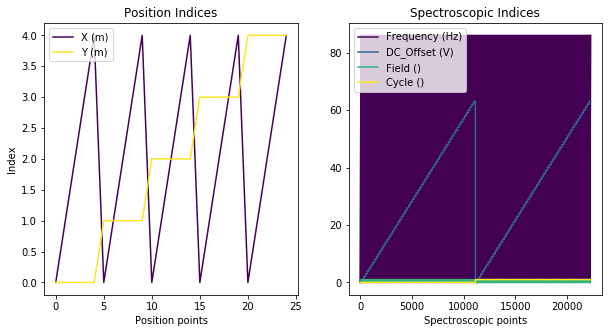

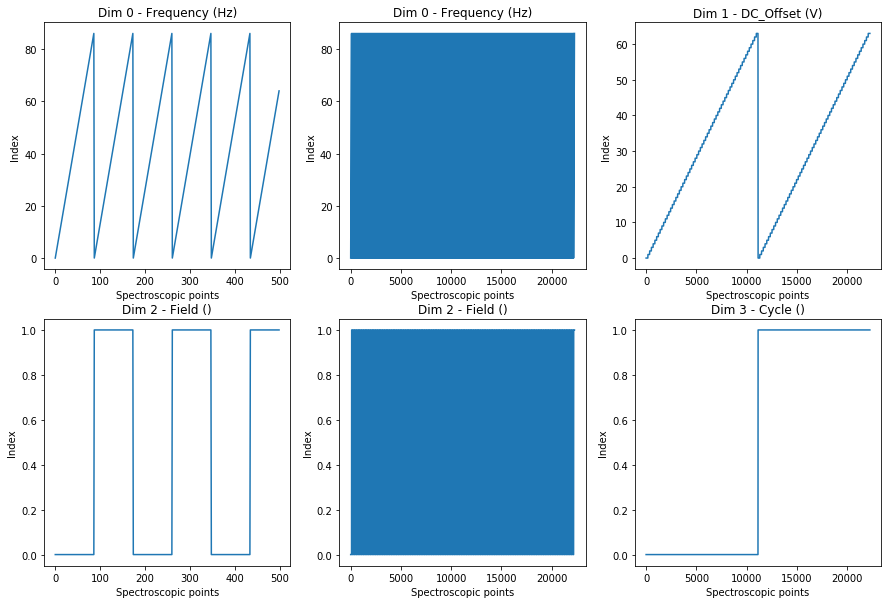

In [8]:
fig_1, axes = plt.subplots(ncols=2, figsize=(10,5))
px.plot_utils.plot_line_family(axes[0], np.arange(h5_pos_ind.shape[0]), h5_pos_ind[()].T, 
                               line_names=pos_labels)
axes[0].set_xlabel('Position points')
axes[0].set_ylabel('Index')
axes[0].set_title('Position Indices')
axes[0].legend()
px.plot_utils.plot_line_family(axes[1], np.arange(h5_spec_ind.shape[1]), h5_spec_ind, 
                               line_names=spec_labels)
axes[1].set_xlabel('Spectroscopic points')
axes[1].set_title('Spectroscopic Indices')
axes[1].legend()

fig_2, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
for dim_ind, axis, dim_label, dim_array in zip([0,2], [axes.flat[0], axes.flat[3]], 
                                               [spec_labels[0], spec_labels[2]], 
                                               [h5_spec_ind[0,:500], h5_spec_ind[2,:500]]):
    axis.plot(np.arange(dim_array.size), dim_array)
    axis.set_xlabel('Spectroscopic points')
    axis.set_ylabel('Index')
    axis.set_title('Dim ' + str(dim_ind) + ' - ' + dim_label)
    
rhs_axes = [axes.flat[ind] for ind in [1,2,4,5]]
for dim_ind, axis, dim_label, dim_array in zip(range(h5_spec_ind.shape[0]), rhs_axes, spec_labels, h5_spec_ind):
    axis.plot(np.arange(dim_array.size), dim_array)
    axis.set_xlabel('Spectroscopic points')
    axis.set_ylabel('Index')
    axis.set_title('Dim ' + str(dim_ind) + ' - ' + dim_label)

## Preparing the Main dataset

Visualization in itself mainly involves slicing the multidimensional dataet to get the lower dimensional images / line plots that can be plotted. Thus, we need to be familar with slicing multidimensional arrays. We have a tutorial on this topic that show two approaches for slicing data. 
1. The easier method - reshape the data to N dimensions and slice the dataset
2. The harder method - find the spectroscopic and position indices of interest and slice the 2D dataset

We will be using the first approach for illustrative purposes. However, note that the second approach may need to be used when visualizing very large datasets that cannot feasibly be loaded entirely into memory - something we do in the first approach. 

We will use convenient pycroscopy function that safely reshapes the data to its N dimensional form with a single line. Note that while this approach appears simple on the surface, there are a fair number of lines of code that make up this function.

In [9]:
ds_nd, success, labels = px.hdf_utils.reshape_to_Ndims(h5_main, get_labels=True)
print('Shape of the N-dimensional dataset:', ds_nd.shape)
print(labels)

Shape of the N-dimensional dataset: (5, 5, 87, 2, 64, 2)
['X' 'Y' 'Frequency' 'Field' 'DC_Offset' 'Cycle']


Now that we have the data in its original N dimensional form, we can easily slice the dataset. For example, if we want to visulize the spectrogram at the third row, second coulmn, fir the first field, and the second cycle, we would slice as follows:

In [16]:
spectrogram = ds_nd[2,3, :, 0, :, 1]
# Now the spectrogram is of order (frequency x DC_Offset).
spectrogram = spectrogram.T
# Now the spectrogram is of order (DC_Offset x frequency)

## Preparing static plots
Before getting into interactive plots, it is prudent to prototype what the plots would look like for example paramaeters. This provides an oppurtunity to debug and fine tune details such as the tick labels etc. The same code can and will be reused when setting up interactive plots. 

### Basic plots:
This is the very basic that could be done for visualization. For more systematic visualization, we will tweak the font sizes, tick labels, etc. in the next cell.

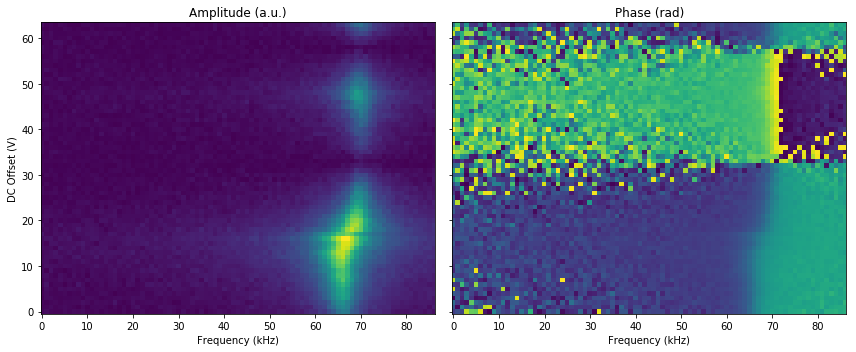

In [39]:
fig, axes = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(12,5))

for axis_ind, axis, oper, title in zip(range(2), axes, [np.abs, np.angle],
                                       ['Amplitude (a.u.)', 'Phase (rad)']):
    im1 = axis.imshow(oper(spectrogram), origin='lower')
    axis.set_title(title)
    axis.set_xlabel('Frequency (index)')
    if axis_ind == 0: 
        axis.set_ylabel('DC Offset (index)')

plt.tight_layout()

For nicer looking plots we need to prepare a few arrays and ancillary pieces of information for the plots:

In [77]:
# Prepare the points at which x and y ticks will be inserted.
# Here, we want five evenly spaced tick marks that cover each axis
# We prepare this ahead of the for loop since this is the same for each plot
x_ticks = np.linspace(0, spectrogram.shape[1] - 1, 5, dtype=np.uint16)
y_ticks = np.linspace(0, spectrogram.shape[0] - 1, 5, dtype=np.uint16)

# We will call this handy function to get the values for the frequency, DC offset
# and all other spectral dimensions. These will be necessary for the X and Y
# tick labels for the plots and for the interactive elements.
unit_spec_vals = px.hdf_utils.get_unit_values(h5_spec_ind, h5_spec_val)

With the ancillary information prepared, we can upgrade the plots

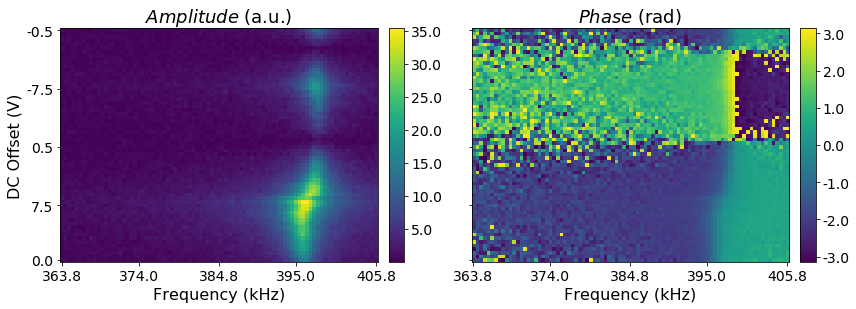

In [95]:
# Use this appraoch to add colorbars to plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(12,7))

for axis_ind, axis, oper, scale, title in zip(range(2), axes, 
                                              [np.abs, np.angle], [1E+3, 1],
                                              ['$Amplitude$ (a.u.)', 
                                               '$Phase$ (rad)']):
    im1 = axis.imshow(scale*oper(spectrogram), origin='lower')
    # This is the procedure to add the colorbar:
    divider = make_axes_locatable(axis)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cbar = plt.colorbar(im1, cax = cax, format="%.1f")
    cbar.ax.tick_params(labelsize=14)
    # Adding the standard labels and titles:
    axis.set_title(title, fontsize=18)
    axis.set_xlabel('Frequency (kHz)', fontsize=16)
    if axis_ind: # second axis
        axis.set_yticks([])
    else:
        axis.set_yticklabels(unit_spec_vals['DC_Offset'][y_ticks])
        axis.set_ylabel('DC Offset (V)', fontsize=16)
    # Custom x and y ticks
    axis.set_xticks(x_ticks)
    axis.set_yticks(y_ticks)
    axis.set_xticklabels(np.round(unit_spec_vals['Frequency'][x_ticks]*1E-3,1))
    
px.plot_utils.set_tick_font_size(axes, 14)

plt.tight_layout()

## Constructing Interactive Plots

We will be using __ipython widgets__ to add the interactivity to the above plots. 

ipython has a variety of widgets available and we will only be using sliders for simplicity. See this link - https://github.com/jupyter-widgets/ipywidgets/blob/master/docs/source/examples/Index.ipynb for more information

The process mainly contains three parts or sections
1. Generating static plots - same as the cell above
2. The function that will update the spectrograms upon change of parameters
    * This function will be called each time the interactive parameters are updated
    * We use the provided parameters to slice the N dimensional main dataset
    * To ensure smooth interactivity, we only update the data within the plots instead of calling the imshow function again
3. Set up of the interactive parameters and calling the interact function
    * Any number of widgets can be used with the interact function
    * The values for each slider are specified as a range: (start, stop, step)
    * The parameters for interact are specified as a dictionary
    
All three components can be incorporated into generalized functions wherever applicable

In [100]:
spec_dim_names_rem = [item for item in spec_dim_names if item not in ['Frequency', 'DC_Offset']]

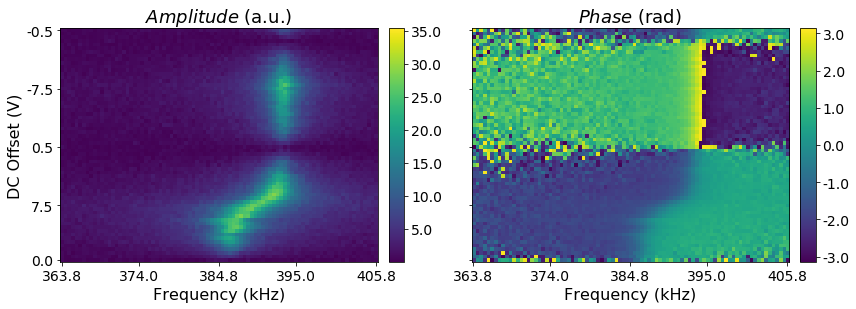

In [101]:
# SECTION 1 - STATIC PLOTS ----------------------------------

# The only difference with the previous cell is that this time, we hang onto
# the image handles so that we can update the plots
im_handles = [] 

fig, axes = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(12,7))

for axis_ind, axis, oper, scale, title in zip(range(2), axes, 
                                              [np.abs, np.angle], [1E+3, 1],
                                              ['$Amplitude$ (a.u.)', 
                                               '$Phase$ (rad)']):
    im1 = axis.imshow(scale*oper(spectrogram), origin='lower')
    # Add this image handle to the list above:
    im_handles.append(im1)
    
    # This is the procedure to add the colorbar:
    divider = make_axes_locatable(axis)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cbar = plt.colorbar(im1, cax = cax, format="%.1f")
    cbar.ax.tick_params(labelsize=14)
    # Adding the standard labels and titles:
    axis.set_title(title, fontsize=18)
    axis.set_xlabel('Frequency (kHz)', fontsize=16)
    if axis_ind: # second axis
        axis.set_yticks([])
    else:
        axis.set_yticklabels(unit_spec_vals['DC_Offset'][y_ticks])
        axis.set_ylabel('DC Offset (V)', fontsize=16)
    # Custom x and y ticks
    axis.set_xticks(x_ticks)
    axis.set_yticks(y_ticks)
    axis.set_xticklabels(np.round(unit_spec_vals['Frequency'][x_ticks]*1E-3,1))
px.plot_utils.set_tick_font_size(axes, 14)
plt.tight_layout()

# SECTION 2 - UPDATING FUNCTION ----------------------------------

def update_spectrograms(**parms):
    # step 1: extracting the parameters
    col_ind = parms['X']
    row_ind = parms['Y']
    field_ind = parms['Field']
    cycle_ind = parms['Cycle']
    
    print('Parameters received by updated_spectrogram:', parms)
    
    # step 2: slicing the data to get the spectrogram
    spectrogram = ds_nd[col_ind,row_ind, :, field_ind, :, cycle_ind]
    # Now the spectrogram is of order (frequency x DC_Offset).
    spectrogram = spectrogram.T
    # Now the spectrogram is of order (DC_Offset x frequency)
    
    # step 3: only update the data of each plot instead of redrawing:
    for im_handle, oper, scale in zip(im_handles, [np.abs, np.angle], [1E+3, 1]):
        im_handle.set_data(scale*oper(spectrogram))
    
    # step 4: request to update the figure:
    display(fig)
    
# SECTION 3 - SET UP PARAMETERS FOR AND CALL INTERACTIVE FUNCTION -------------

# make this more automated:
parms = {'X':(0,4,1), 'Y':(0,4,1), 'Cycle':(0,1,1), 'Field':(0,1,1)}

widgets.interact(update_spectrograms, **parms);

## Closing the file

In [23]:
h5_file.close()
#os.remove(h5_path)